In [12]:
import numpy as np
import random as rd
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
from itertools import product
from matplotlib.animation import ArtistAnimation
from IPython.display import Image

In [95]:
class Forest:
    
    def __init__(self, L):
        
        self.L = L
        self.arr = np.zeros((L, L))
        self.trees = list(product(range(0, L), range(0, L)))
        self.inds = {self.trees[i]: i for i in range(len(self.trees))}
        self.neighbors = [self.get_neighbors(i[0], i[1]) for i in self.trees]
        self.label_list = np.arange(L*L)
        
    def get_neighbors(self, row, col):

        row_indices = [row-1, row, row+1]
        col_indices = [col-1, col, col+1]
        neighbors = [(r, c) for r, c in product(row_indices, col_indices) if 0 <= r < self.L and 0 <= c < self.L]
        neighbors.remove((row, col))

        return list(neighbors)
    
    def populate_forest(self, p):
        
        N = len(self.trees)
        unifs = np.random.uniform(size=N)
        populate = [self.trees[i] for i in range(N) if unifs[i] < p]
        if len(populate) > 0:
            rows, cols = zip(*populate)
            self.arr[rows, cols] = 1
        
    def fire(self):
        
        start_edge = [i for i in self.trees if i[1] == 0]
        start_states = self.arr[[i[0] for i in start_edge], [i[1] for i in start_edge]]
        burning = [start_edge[i] for i in range(len(start_edge)) if start_states[i] == 1]
        
        if len(burning) > 0:
            
            rows, cols = zip(*burning)
            self.arr[rows, cols] = -1

            end_edge = [i for i in self.trees if i[1] == self.L - 1]
            end_states = self.arr[[i[0] for i in end_edge], [i[1] for i in end_edge]]

            while np.any(self.arr == -1) and not np.any(end_states == -1):

                for tree in burning:
                    ind = self.inds[tree]
                    neighbors = self.neighbors[ind]
                    neighbors_states = self.arr[[i[0] for i in neighbors], [i[1] for i in neighbors]]
                    to_burn = [neighbors[i] for i in range(len(neighbors)) if neighbors_states[i] == 1]
                    if len(to_burn) > 0:
                        rows, cols = zip(*to_burn)
                        self.arr[rows, cols] = -1

                rows, cols = zip(*burning)
                self.arr[rows, cols] = 2
                burn_inds = np.where(self.arr == -1)
                burning = list(zip(burn_inds[0], burn_inds[1]))
                end_states = self.arr[[i[0] for i in end_edge], [i[1] for i in end_edge]]

            outcome = 1 if np.any(end_states == -1) else 0

            return outcome
        
        else:
            return 0
        
    def fire_anim(self):
        
        initial_state = np.copy(self.arr)
        
        start_edge = [i for i in self.trees if i[1] == 0]
        start_states = self.arr[[i[0] for i in start_edge], [i[1] for i in start_edge]]
        burning = [start_edge[i] for i in range(len(start_edge)) if start_states[i] == 1]
        rows, cols = zip(*burning)
        self.arr[rows, cols] = -1
        
        cur_state = self.arr
        forest_states = np.vstack((initial_state, cur_state))
        
        end_edge = [i for i in self.trees if i[1] == self.L - 1]
        end_states = self.arr[[i[0] for i in end_edge], [i[1] for i in end_edge]]
        
        steps = 2
        
        while np.any(self.arr == -1) and not np.any(end_states == -1):
            
            for tree in burning:
                ind = self.inds[tree]
                neighbors = self.neighbors[ind]
                neighbors_states = self.arr[[i[0] for i in neighbors], [i[1] for i in neighbors]]
                to_burn = [neighbors[i] for i in range(len(neighbors)) if neighbors_states[i] == 1]
                if len(to_burn) > 0:
                    rows, cols = zip(*to_burn)
                    self.arr[rows, cols] = -1
            
            cur_state = self.arr
            forest_states = np.vstack((forest_states, cur_state))
            rows, cols = zip(*burning)
            self.arr[rows, cols] = 2
            burn_inds = np.where(self.arr == -1)
            burning = list(zip(burn_inds[0], burn_inds[1]))
            end_states = self.arr[[i[0] for i in end_edge], [i[1] for i in end_edge]]
            steps += 1

        forest_states = [forest_states[i*self.L:(i+1)*self.L, :] for i in range(steps)]
        
        return forest_states
    
    def find(self, cur_label):
        
        label = cur_label
        
        while self.label_list[label] != label:
            label = self.label_list[label]
            
        while self.label_list[cur_label] != cur_label:
            new_label = self.label_list[cur_label]
            self.label_list[cur_label] = label
            cur_label = new_label
            
        return label
    
    def union(self, label1, label2):
        
        self.label_list[self.find(label1)] = self.find(label2)            
                    
    def hoshen_kopelman(self):
        
        L = self.L
        labels = np.zeros((L, L), dtype=int)
        label_counter = 0
        
        for row in range(L):
            for col in range(L):  
                
                if self.arr[row, col] == 2:
                    neighbors = self.get_neighbors(row, col)
                    neighbor_labels = [labels[r, c] for r, c in neighbors if labels[r, c] != 0]

                    if len(neighbor_labels) == 0:
                        label_counter += 1
                        labels[row, col] = label_counter
                    else:
                        min_label = min(neighbor_labels)
                        labels[row, col] = min_label
                        for label in neighbor_labels:
                            if label != min_label:
                                self.union(label, min_label) 
                                
        return labels

#### Animation

In [14]:
f = Forest(100)
f.populate_forest(0.5)

In [15]:
frames = f.fire_anim()

In [16]:
%%capture
fig, ax = plt.subplots()

artists = []

for frame in frames:
    heatmap = ax.imshow(frame, cmap='plasma', interpolation='bicubic')
    artists.append([heatmap])

ani = ArtistAnimation(fig, artists, interval=200, blit=True) 
ani.save('heatmap_animation.gif', writer='pillow')

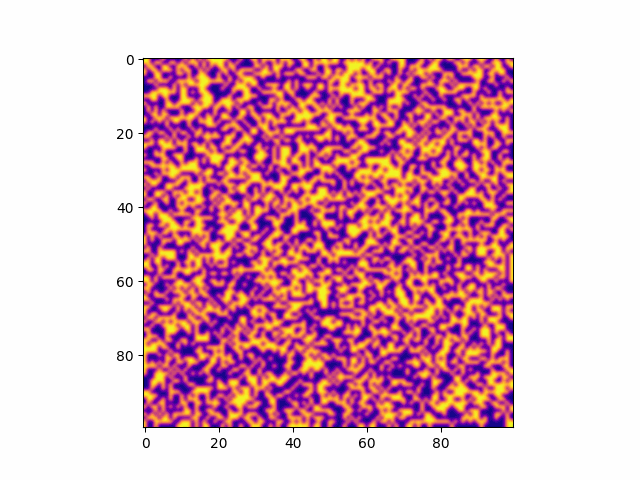

In [17]:
Image(filename='heatmap_animation.gif')

#### Percolation threshold

In [110]:
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (10, 6)
style.use('seaborn-v0_8')
# style.use('seaborn')

In [66]:
ps = np.arange(0.01, 1, 0.01)

In [67]:
prob20 = np.zeros(len(ps))
prob50 = np.zeros(len(ps))
prob100 = np.zeros(len(ps))

In [68]:
for i, p in enumerate(ps):
    
    out20 = np.zeros(100)
    out50 = np.zeros(100)
    out100 = np.zeros(100)
    
    for j in range(100):
        
        f20 = Forest(20)
        f20.populate_forest(p)
        out20[j] = f20.fire()
        
        f50 = Forest(50)
        f50.populate_forest(p)
        out50[j] = f50.fire()
        
        f100 = Forest(100)
        f100.populate_forest(p)
        out100[j] = f100.fire()
        
        
    prob20[i] = np.mean(out20)
    prob50[i] = np.mean(out50)
    prob100[i] = np.mean(out100)

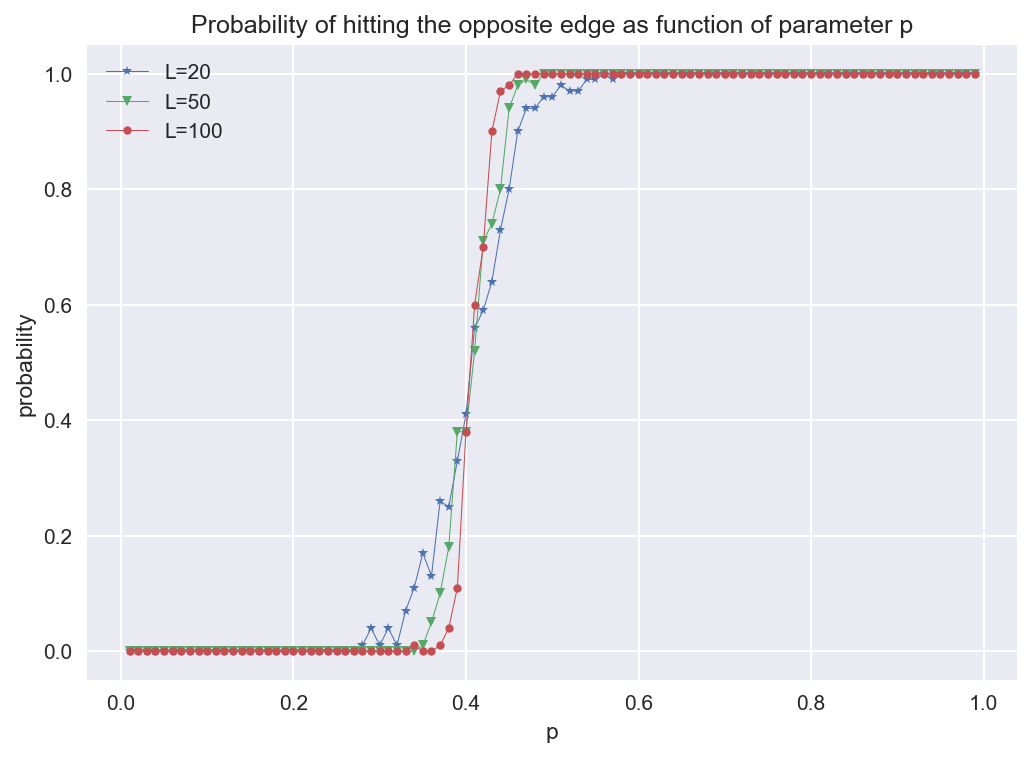

In [73]:
plt.plot(ps, prob20, label='L=20', marker='*', linewidth=0.5, markersize=5)
plt.plot(ps, prob50, label='L=50', marker='v', linewidth=0.5, markersize=5)
plt.plot(ps, prob100, label='L=100', marker='o', linewidth=0.5, markersize=4)
plt.legend()
plt.title('Probability of hitting the opposite edge as function of parameter p')
plt.xlabel('p')
plt.ylabel('probability')
plt.savefig('percolation.png')

#### Clustering

In [172]:
ps = np.arange(0.01, 1, 0.01)
biggest_clust = np.zeros(len(ps))

In [173]:
for i, p in enumerate(ps):
    bc = np.zeros(100)
    for j in range(100):
        f = Forest(100)
        f.populate_forest(p)
        f.fire()
        clusters = f.hoshen_kopelman()
        labels, counts = np.unique(clusters, return_counts=True)
        if 0 in labels:
            labels = labels[1:]
            counts = counts[1:]
            
        bc[j] = max(counts) if len(counts) > 0 else 0
        
    biggest_clust[i] = np.mean(bc)

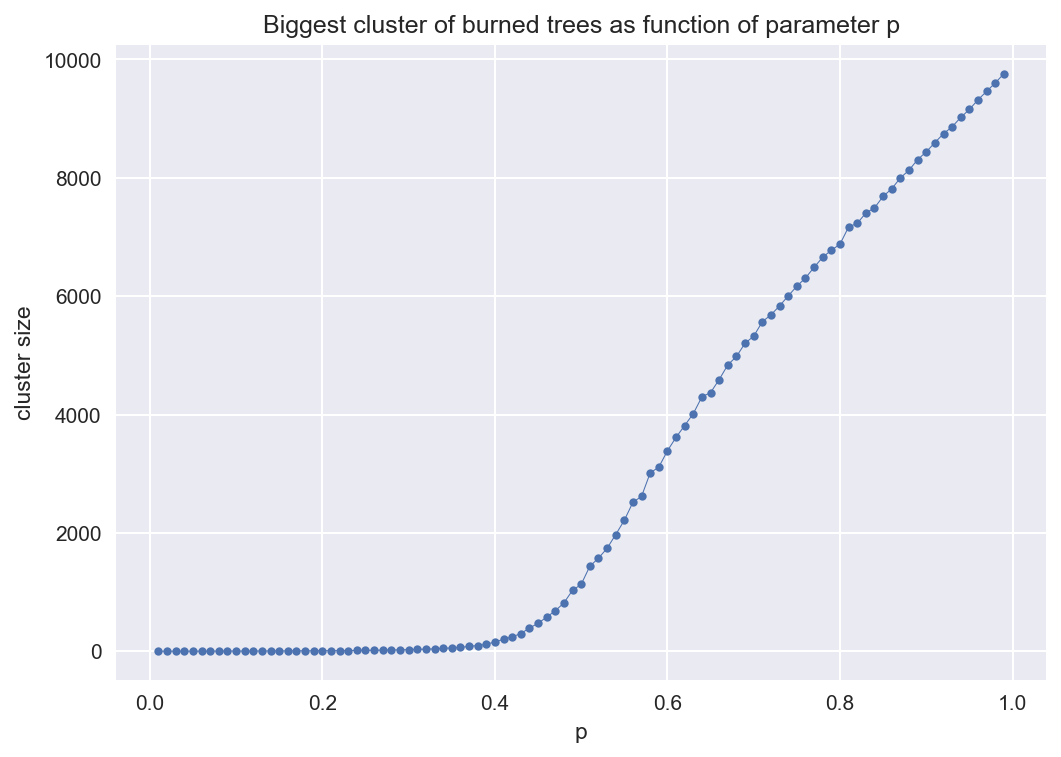

In [174]:
plt.plot(ps, biggest_clust, marker='o', linewidth=0.5, markersize=4)
plt.title('Biggest cluster of burned trees as function of parameter p')
plt.xlabel('p')
plt.ylabel('cluster size')
plt.savefig('biggest_clust.png')